In [1]:
from joblib import parallel_backend
def parallel():
    return parallel_backend('threading', n_jobs=-1)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, \
    StackingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from datetime import datetime
import random
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

DATA_PATH_TRAIN = './train.csv'
DATA_PATH_TEST = './test.csv'

Загрузим данные для обучения и проверки модели:

In [4]:
train0 = pd.read_csv(DATA_PATH_TRAIN)
test0 = pd.read_csv(DATA_PATH_TEST)
print(f'Строк и полей в Train: {train0.shape}, строк и полей в Test: {test0.shape}.')
train0.describe()

Строк и полей в Train: (10000, 20), строк и полей в Test: (5000, 19).


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


<AxesSubplot:>

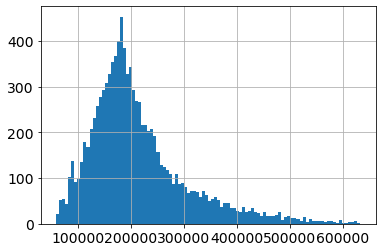

In [5]:
train0['Price'].hist(bins=100)

Функции и классы для подготовки данных и оценки результата модели:

In [6]:
def evaluate_predictions(train_true, train_predicted, test_true, test_predicted, label=''):
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_predicted, y=train_true)
    plt.xlabel(f'{label} Train Predicted')
    plt.ylabel(f'{label} Train True')
    plt.title(f'{label} Train Predicted vs True values')
    
    plt.subplot(122)
    sns.scatterplot(x=test_predicted, y=test_true)
    plt.xlabel(f'{label} Test Predicted')
    plt.ylabel(f'{label} Test True')
    plt.title(f'{label} Test Predicted vs True values')
    
    plt.show()
    
    print(f'{label} Train R2: {round(r2_score(train_true, train_predicted), 3)}')
    print(f'{label} Test R2:  {round(r2_score(test_true, test_predicted), 3)}')

In [7]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""
        
        X = X.copy()

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] <= 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [8]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = 1945 #df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        X = X.copy()
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        #if self.med_price_by_district is not None:
        #    X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        #    X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        X['floor_relative'] = X['Floor'] / X['HouseFloor']
            
        X.drop(['Id', 'DistrictId'], axis=1, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, 30, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [1940, 1963, 1970, 1980, 1990, 2000, 2014, self.house_year_max]
        #bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X

Разделим данные на обучающие и тестовые:

In [9]:
X = train0.drop(columns='Price')
y = train0['Price']

X_train0, X_valid0, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

Обработка данных и генерация фичей:

In [10]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train0)

X_train1 = preprocessor.transform(X_train0)
X_valid1 = preprocessor.transform(X_valid0)
test1 = preprocessor.transform(test0)

features_gen = FeatureGenerator()
features_gen.fit(X_train1, y_train)
X_train = features_gen.transform(X_train1)
X_valid = features_gen.transform(X_valid1)
test_df = features_gen.transform(test1)

X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,floor_cat,year_cat,MedPriceByFloorYear,floor_relative
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.00000,6700.000000,6700.000000,6700.000000,6700.000000
mean,1.883731,56.115967,39.832498,6.187612,7.302836,12.835373,1984.665522,0.118484,0.989851,0.972836,...,0.000746,0.182090,0.000299,0.213134,164.040299,0.38791,1.563731,2.794179,197872.413312,0.605338
std,0.808821,21.770372,22.527969,2.735413,4.989683,6.439464,18.361489,0.119817,0.100238,0.162574,...,0.027310,0.385947,0.017276,0.409552,181.693963,0.48731,1.415574,1.809281,30840.444203,0.279460
min,1.000000,1.136859,0.370619,3.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,-1.000000,-1.000000,97480.845791,0.041667
25%,1.000000,41.700567,24.870420,3.000000,3.000000,9.000000,1973.000000,0.017647,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,38.000000,0.00000,0.000000,2.000000,178520.221429,0.357143
50%,2.000000,52.300299,35.367879,6.000000,6.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,71.000000,0.00000,2.000000,2.000000,184089.852871,0.600000
75%,2.000000,65.671500,48.682624,8.000000,10.000000,17.000000,2000.000000,0.194489,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,349.000000,1.00000,3.000000,4.000000,213169.444285,0.857143
max,5.000000,641.065193,638.163193,12.000000,42.000000,117.000000,2022.000000,0.521867,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,568.000000,1.00000,5.000000,6.000000,429090.881284,1.000000


Используем различные модели и оценим их точность:

In [11]:
models = {}

def fit(name, model):
    with parallel():
        model.fit(X_train, y_train)
    models[name] = model

def evaluate_models():
    with parallel():
        for name, model in models.items():
            y_train_pred = model.predict(X_train)
            y_valid_pred = model.predict(X_valid)
            evaluate_predictions(y_train, y_train_pred, y_valid, y_valid_pred, label=f'{name}:')        

In [12]:
fit('HistGradientBoostingRegressor', HistGradientBoostingRegressor(random_state=21,
    max_leaf_nodes=30, max_iter=1000, learning_rate=0.019, max_depth=12))

In [13]:
fit('GradientBoostingRegressor', GradientBoostingRegressor(criterion='mse', learning_rate=0.027,
    loss='huber', max_depth=6, max_features='sqrt', min_samples_leaf=40, n_estimators=2400, random_state=21))

In [14]:
# fit('StackingRegressor', StackingRegressor([
#     ('hg', models['HistGradientBoostingRegressor']),
#     ('gb', models['GradientBoostingRegressor'])
# ]))

In [15]:
fit('VotingRegressor', VotingRegressor([
    ('hg', models['HistGradientBoostingRegressor']),
    ('gb', models['GradientBoostingRegressor'])
]))

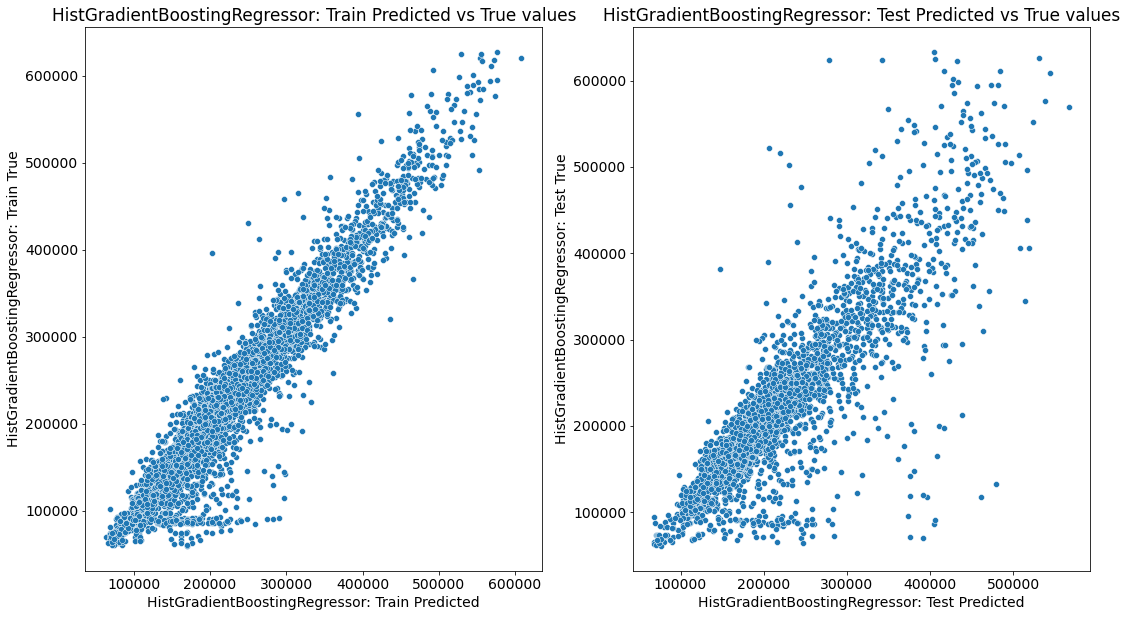

HistGradientBoostingRegressor: Train R2: 0.914
HistGradientBoostingRegressor: Test R2:  0.743


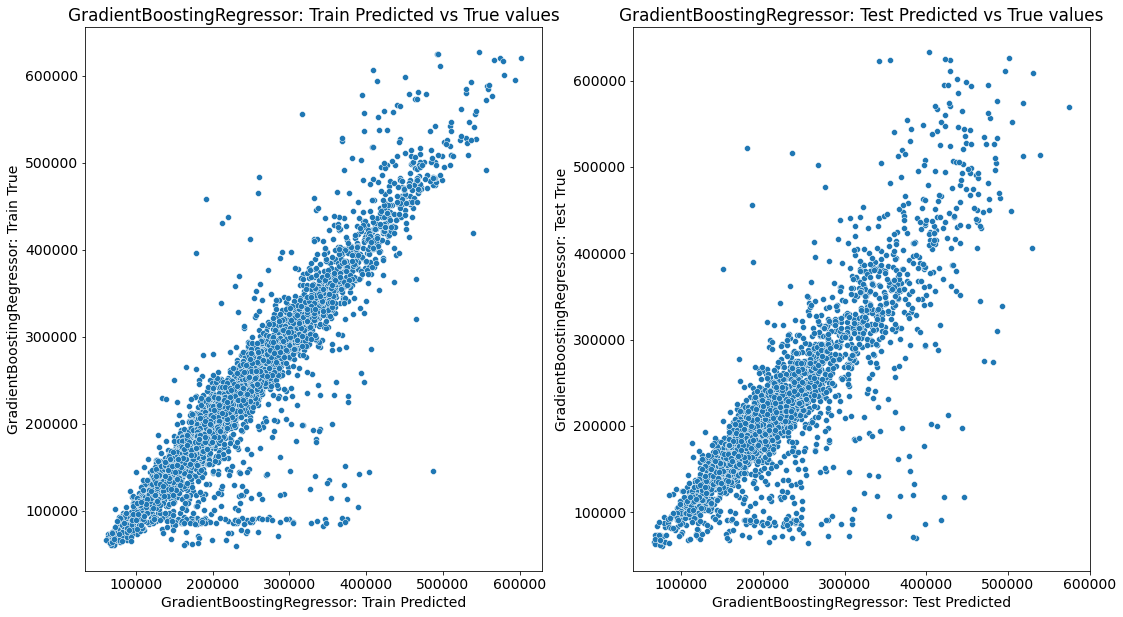

GradientBoostingRegressor: Train R2: 0.875
GradientBoostingRegressor: Test R2:  0.751


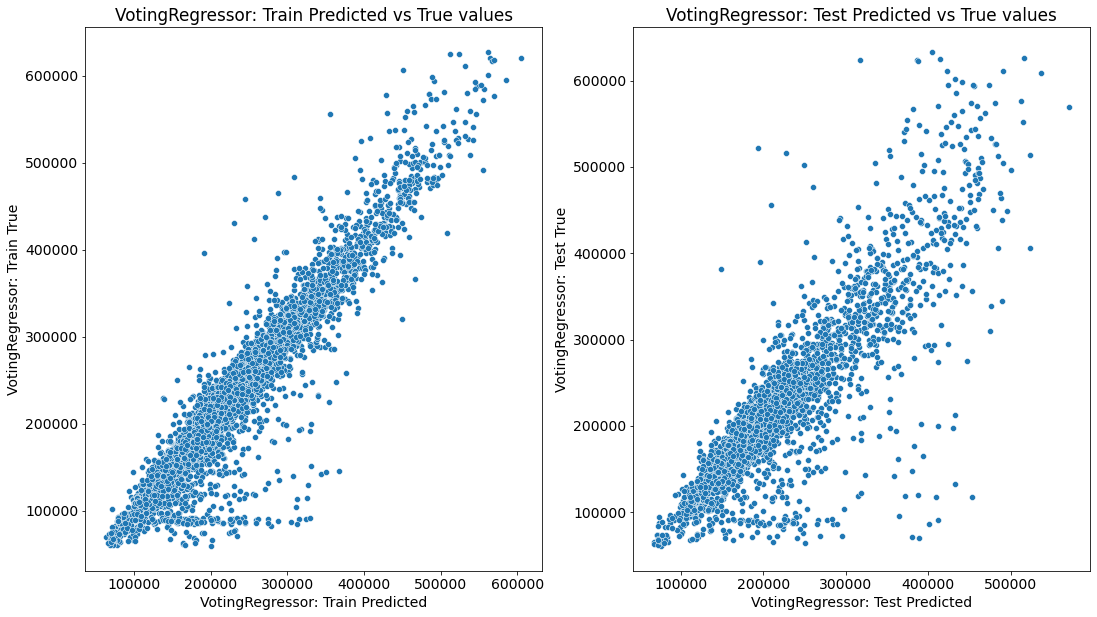

VotingRegressor: Train R2: 0.9
VotingRegressor: Test R2:  0.752


In [16]:
evaluate_models()

In [17]:
submit = test0[['Id']]
submit['Price'] = models['VotingRegressor'].predict(test_df)
submit.to_csv('submit.csv', index=False)
submit

KeyError: 'StackingRegressor'